# Лабораторная работа №1 по дисциплине "Основы машинного обучения"

Выполнили cтуденты группы 3311:
- Шарпинский Денис
- Локтионов Тимофей
- Суздалева Алёна

Требования:
- Число столбцов признаков – 10 и более.
- Число записей – не менее 10000.
- Набор данных имеет пропуски.

Задачи:
- Очистка данных (удаление пропусков, нормализация, удаление дубликатов).
- Визуализация значимых признаков.
- диаграммы рассеяния.
- ящики с усами.
- гистограммы.
- Корреляция данных (матрица корреляций и статистический анализ).

Датасет: https://www.kaggle.com/datasets/adilshamim8/exploring-mental-health-data/code.

В датасете 140700 строк и 20 признаков.

# Импорты

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Константы

In [357]:
URL_TRAIN = "https://raw.githubusercontent.com/Pyc-Nya/year3/main/sem5/ai/train.csv"
URL_TEST = "https://raw.githubusercontent.com/Pyc-Nya/year3/main/sem5/ai/test.csv"
TARGET_COL = "Depression"

# Чтение данных

In [358]:
def load_data(url):
    return pd.read_csv(url)

df_train_raw = load_data(URL_TRAIN)
df_test_raw = load_data(URL_TEST)

print(f"Train: {df_train_raw.shape}")
print(f"Test: {df_test_raw.shape}")

Train: (140700, 20)
Test: (93800, 19)


# Общая информация

In [359]:
print("\n=== СТРУКТУРА ДАТАСЕТА ===")
print(f"Всего столбцов: {len(df_train_raw.columns)}")

print("\n=== ТИПЫ ДАННЫХ ===")
print(df_train_raw.dtypes)

print("\n=== БАЗОВАЯ СТАТИСТИКА ===")
print(df_train_raw.describe())

print("\n=== ПЕРВЫЕ 5 СТРОК ===")
print(df_train_raw.head())

print("\n=== Вывод количества ненулевых значений ===")
print(df_train_raw.info())


=== СТРУКТУРА ДАТАСЕТА ===
Всего столбцов: 20

=== ТИПЫ ДАННЫХ ===
id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
D

# Функция анализа данных

В последующих секциях мы проводим анализ данных. Представлены функции для:
1. Анализа категориальных данных
2. Анализа пропусков
3. Анализа баланса классов
4. Поиск порогового значения для последующей обработки, эта функция будет использоваться далее, но идеологически она является аналитической функцией, поэтому расположена здесь. Разберём её отдельно.

Для обработки городов и уровня образования было необходимо произвести обобщение данных из сотни возможных вариантов получить, скажем, 30.

Рассмотрим на примере городов. Мы формируем частотный словарь, а именно, сколько человек приходится на тот или иной город. Затем функция перебирает возможные пороговые значения (от большего к меньшему) и для каждого порога проверяет:
   - Сколько групп (городов) останется, если оставить только те, где количество людей >= порога
   - Какой процент данных будет покрыт этими группами
   
Функция возвращает первый порог, который удовлетворяет двум условиям:
   - Покрытие данных >= `min_coverage` (например, 80%)
   - Количество групп >= `min_groups` (например, 10)
   
Это позволяет сбалансировать детализацию данных и их обобщение: мы сохраняем достаточно групп для анализа, но при этом покрываем большую часть выборки, избегая чрезмерной фрагментации на редкие категории.

In [360]:
def analyze_categorical_columns(df):
    """Показывает все уникальные значения для категориальных столбцов"""

    # Выбираем только категориальные столбцы (object)
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(f"=== КАТЕГОРИАЛЬНЫЕ СТОЛБЦЫ ({len(categorical_cols)}) ===\n")

    for col in categorical_cols:
        unique_count = df[col].nunique()
        missing = df[col].isnull().sum()

        print(f"- {col}")
        print(f"   Уникальных: {unique_count}, Пропусков: {missing}")

        # Если значений мало — показываем все
        if unique_count <= 10:
            print(f"   Значения: {df[col].unique().tolist()}")
        else:
            # Если много — показываем топ-5
            top5 = df[col].value_counts().head(5)
            print(f"   Топ-5: {top5.to_dict()}")

        print()

def analyze_missing(df):
    missing_percent = (df.isnull().sum() / len(df)) * 100
    return missing_percent[missing_percent > 0]

def analyze_class_balance(df, target):
    counts = df[target].value_counts()
    print(f"Класс 0: {counts[0]} ({counts[0]/len(df)*100:.1f}%)")
    print(f"Класс 1: {counts[1]} ({counts[1]/len(df)*100:.1f}%)")

def find_optimal_threshold(df, column_name, min_coverage, min_groups):
    group_sizes = df[column_name].value_counts().sort_values(ascending=False)
    total = len(df)
    possible_thresholds = sorted(group_sizes.unique(), reverse=True)

    for threshold in possible_thresholds:
        count = (group_sizes >= threshold).sum()
        people_covered = group_sizes[group_sizes >= threshold].sum()
        percent = (people_covered / total) * 100

        if percent >= min_coverage and count >= min_groups:
            print(f"\nОптимальный порог для {column_name}: {threshold}")
            print(f"  Групп: {count}, Покрытие: {percent:.1f}%")
            return threshold

    default = 50
    print(f"\n Используется порог по умолчанию: {default}")
    return default

# Анализ

In [361]:
print("\n" + "="*60)
print("АНАЛИЗ ПРИЗНАКОВ")
print("="*60)

# Категориальные столбцы
print("\nКАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:")
categorical_cols = df_train_raw.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique = df_train_raw[col].nunique()
    missing_pct = df_train_raw[col].isnull().sum() / len(df_train_raw) * 100
    print(f"  - {col}: {unique} значений, {missing_pct:.1f}% пропусков")

# Числовые столбцы
print("\nЧИСЛОВЫЕ ПРИЗНАКИ:")
numeric_cols = df_train_raw.select_dtypes(include=[np.number]).columns
print(f"  Всего: {len(numeric_cols)}")

print("\n" + "="*60)
print("РЕШЕНИЯ ПО ОБРАБОТКЕ")
print("="*60)

# === CGPA ===
print("\n CGPA vs ДЕПРЕССИЯ (студенты):")
students = df_train_raw[df_train_raw['CGPA'].notna()]
correlation = students['CGPA'].corr(students['Depression'])
cgpa_no_dep = students[students['Depression'] == 0]['CGPA'].mean()
cgpa_with_dep = students[students['Depression'] == 1]['CGPA'].mean()
print(f"  Корреляция: {correlation:.4f}")
print(f"  Средний CGPA без депрессии: {cgpa_no_dep:.2f}")
print(f"  Средний CGPA с депрессией: {cgpa_with_dep:.2f}")
print(f"  Вывод: слабая связь -> УДАЛЯЕМ")

# === РАБОТА + УЧЕБА одновременно ===
print("\n ПРОВЕРКА: работа + учеба одновременно")
both = (df_train_raw['Academic Pressure'].notna() & df_train_raw['Work Pressure'].notna()).sum()
total = len(df_train_raw)
print(f"  Людей с обоими значениями: {both} из {total} ({both/total*100:.1f}%)")
print(f"  Вывод: идеальное дополнение -> ОБЪЕДИНЯЕМ")

# === DEGREE ===
print("\n ОБРАЗОВАНИЕ vs ДЕПРЕССИЯ:")
degree_stats = df_train_raw[df_train_raw['Degree'].notna()].groupby('Degree')['Depression'].agg(['count', 'mean']).reset_index()
degree_stats.columns = ['Degree', 'total', 'depression_rate']
degree_stats = degree_stats[degree_stats['total'] >= 100]
degree_stats = degree_stats.sort_values('depression_rate', ascending=False)

print(f"  Топ-3 с наибольшей депрессией:")
for _, row in degree_stats.head(3).iterrows():
    print(f"    - {row['Degree']}: {row['depression_rate']*100:.1f}% (n={row['total']})")

print(f"  Разброс: {degree_stats['depression_rate'].min()*100:.1f}% - {degree_stats['depression_rate'].max()*100:.1f}%")
print(f"  СКО: {degree_stats['depression_rate'].std():.3f}")
degree_threshold = find_optimal_threshold(df_train_raw, 'Degree', min_coverage=99, min_groups=20)
print(f"  Вывод: сильная связь -> КОДИРУЕМ (порог {degree_threshold})")

# Пропуски
print("\n УДАЛЯЕМ:")
print("  - id, Name - технические")
print(f"  - CGPA - корреляция {correlation:.2f}, только у студентов (20%)")
print("  - Profession - СКО 0.032, 26% пропусков")
print("  - City - разброс 12.6%-27.5%, нет гарантии совпадения с test")

# Объединяем
print("\n ОБЪЕДИНЯЕМ:")
print("  - Academic/Work Pressure -> Pressure")
print("  - Study/Job Satisfaction -> Satisfaction")

# Очищаем
print("\n ОЧИЩАЕМ ОТ МУСОРА:")
diet_clean = df_train_raw[df_train_raw['Dietary Habits'].isin(['Healthy', 'Moderate', 'Unhealthy'])]
diet_stats = diet_clean.groupby('Dietary Habits')['Depression'].mean()
print(f"  - Dietary Habits: 3 валидных из 23")
print(f"    Unhealthy: {diet_stats['Unhealthy']*100:.1f}%, Moderate: {diet_stats['Moderate']*100:.1f}%, Healthy: {diet_stats['Healthy']*100:.1f}%")

valid_sleep = ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours']
sleep_clean = df_train_raw[df_train_raw['Sleep Duration'].isin(valid_sleep)]
sleep_stats = sleep_clean.groupby('Sleep Duration')['Depression'].mean()
print(f"  - Sleep Duration: 4 валидных из 36, СКО {sleep_stats.std():.3f}")

# Преобразуем
print("\n ПРЕОБРАЗУЕМ:")
print("  - Sleep Duration -> Sleep_Hours (4, 5.5, 7.5, 9)")
print("  - Dietary Habits -> числа (0, 1, 2)")
print("  - Gender, Suicidal Thoughts, Family History -> бинарные (0/1)")

# Баланс классов
print("\n БАЛАНС КЛАССОВ:")
analyze_class_balance(df_train_raw, TARGET_COL)

print("\n" + "="*60)


АНАЛИЗ ПРИЗНАКОВ

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:
  - Name: 422 значений, 0.0% пропусков
  - Gender: 2 значений, 0.0% пропусков
  - City: 98 значений, 0.0% пропусков
  - Working Professional or Student: 2 значений, 0.0% пропусков
  - Profession: 64 значений, 26.0% пропусков
  - Sleep Duration: 36 значений, 0.0% пропусков
  - Dietary Habits: 23 значений, 0.0% пропусков
  - Degree: 115 значений, 0.0% пропусков
  - Have you ever had suicidal thoughts ?: 2 значений, 0.0% пропусков
  - Family History of Mental Illness: 2 значений, 0.0% пропусков

ЧИСЛОВЫЕ ПРИЗНАКИ:
  Всего: 10

РЕШЕНИЯ ПО ОБРАБОТКЕ

 CGPA vs ДЕПРЕССИЯ (студенты):
  Корреляция: 0.0217
  Средний CGPA без депрессии: 7.62
  Средний CGPA с депрессией: 7.69
  Вывод: слабая связь -> УДАЛЯЕМ

 ПРОВЕРКА: работа + учеба одновременно
  Людей с обоими значениями: 0 из 140700 (0.0%)
  Вывод: идеальное дополнение -> ОБЪЕДИНЯЕМ

 ОБРАЗОВАНИЕ vs ДЕПРЕССИЯ:
  Топ-3 с наибольшей депрессией:
    - Class 12: 51.3% (n=14729)
    - B.Tech: 21.4% (n=44

После анализа данных по каждому отдельному столбцу, были приняты следующие решения:
1. Удаление столбцов id, name, т к они не несут существенной информации по теме.
2. Удаление столбца CGPA (успеваемость) по причине низкой корреляции с целевым столбцом, а также этот параметр присутствует только у студентов, которых лишь 20% от общего числа опрошенных.
3. Удалить столбец City, поскольку
   - Нет гарантии, что в тестовых данных будут такие же города.
   - Была предпринята попытка преобразовать данные, для каждого города, количество опрошенных в котором превосходило пороговое значение, мы высчитывали `depression_rate`, для городов, где было опрошено меньшее количество людей (в случае с нашим датасетом - это зачастую от 0 до 5), мы брали среднее значение. Было получено суммарно 30 групп и одна - города с количеством опрошенных меньше порогового значения. В результате стало понятно, что самый "депрессивный" город имеет `depression_rate` лишь 25%, а наименнее депрессивный 17%, что, во-первых, небольшой разброс, а во вторых не так существенно, как, например, возраст или давление от общества. В результате мы решили избавиться от этого столбца.
4. Объединить столбцы `Work pressure` и `Academic pressure`
   - Мы выяснили, что нет людей, которые работают и учатся одновременно или не работают и не учатся одновременно, то есть данные идеально дополняют друг друга, так что логично их объединить.
5. Объединить `Satisfaction`-столбцы по причине, аналогичной из пункта 4.
6. Удалить столбец `Profession` - чересчур много профессий, много пропусков, и из-за слишком малой выборки людей, работающих на конкретной профессии, нельзя однозначно строить выводы о корреляции депрессии и профессии.
7. Преобразовать Degree в Degree_rate. Была выявлена сильная корреляция между уровнем образования и депрессией (половина школьников имеют депрессию), поэтому мы решили оставить этот столбец. С ним была проделана та же работа, что и с городами.
8. Преобразовали `Dietary Habits`, большая часть столбцов принимала ровно 3 значения: `Healthy`, `Moderate`, `Unhealthy`, поэтому мы оставили только эти три, остальные заменив на моду. Впоследствии также заменили строки на числа - 0, 1, 2.
9. `Sleep Duration` был довольно хаотичным столбцом, но ситуация, отчасти, повторялась как с `Dietary Habits`, а также, поскольку это фактически числовой параметр, то мы просто распределили продолжительность сна по 4ём самым популярным группам, в которые входило 99% опрошенных.

# Визуализация


=== ВИЗУАЛИЗАЦИЯ ===


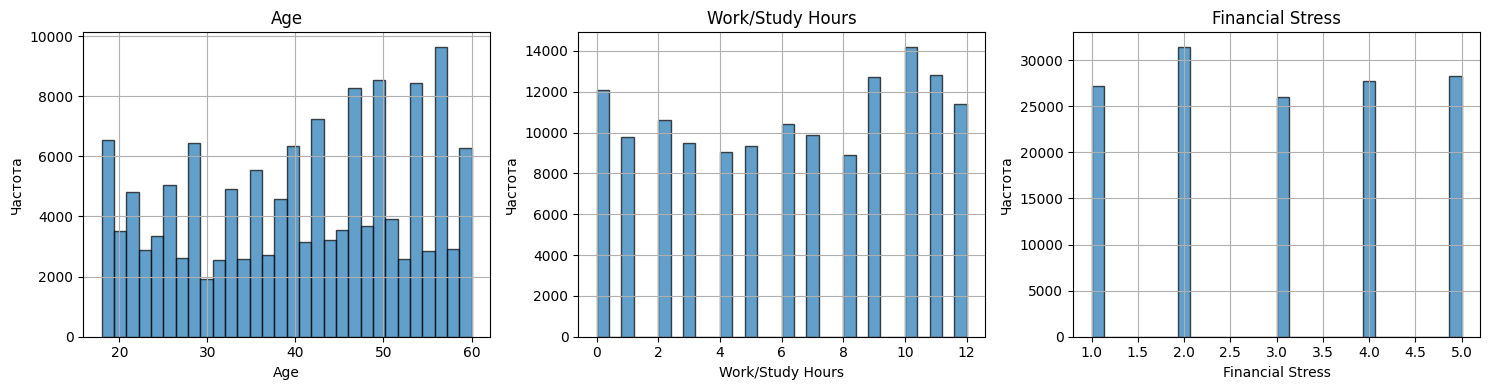

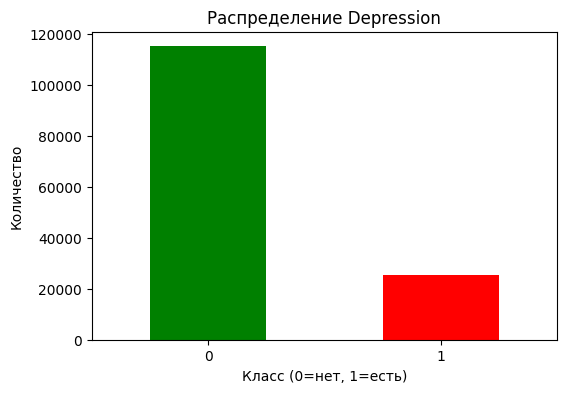

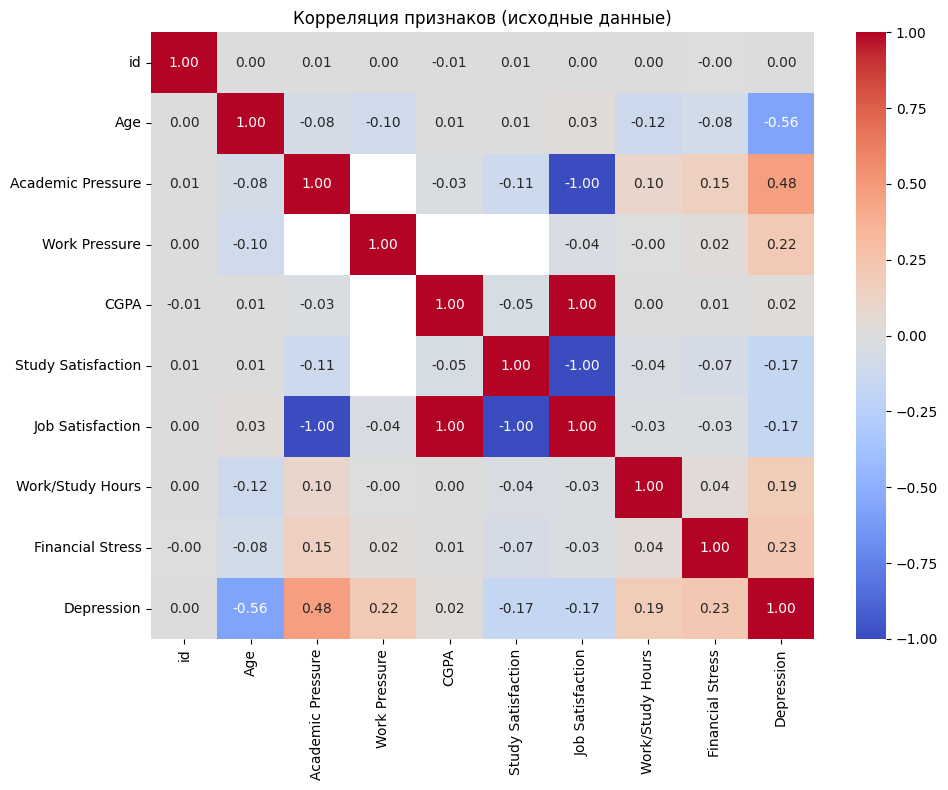

Визуализация завершена


In [362]:
print("\n=== ВИЗУАЛИЗАЦИЯ ===")

# 1. РАСПРЕДЕЛЕНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ (гистограммы)
numeric_cols = ['Age', 'Work/Study Hours', 'Financial Stress']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(numeric_cols):
    df_train_raw[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')
plt.tight_layout()
plt.show()

# 2. БАЛАНС КЛАССОВ
plt.figure(figsize=(6, 4))
df_train_raw['Depression'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение Depression')
plt.xlabel('Класс (0=нет, 1=есть)')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

# 3. КОРРЕЛЯЦИОННАЯ МАТРИЦА (только исходные числовые)
numeric_data = df_train_raw.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция признаков (исходные данные)')
plt.tight_layout()
plt.show()

print("Визуализация завершена")

# Функции обработки данных

Здесь описаны функции обработки данных, которые косвенно были упомянуты в пояснении к анализу данных.

Особую важность здесь имеют две последние функции. Как и было сказано ранее, для уровня образования мы строим map, где ставим в соответствие уровень образования и `depression_rate`.

Но, поскольку часть данных является мусорными или незначительными (99% опрошенных входят в 28 групп из доступных 50 вариантов образования), то мы определили пороговое значение, начиная с которого мы вместо актуального значения подставляем среднее по всем опрошенным.

Также, стоит отметить, что в тестовых данных поля `Depression`, очевидно, нет, поэтому мы не сможем произвести такие же вычисления для тестовых данных. Но нам и не нужно, поскольку мы можем использовать статистику, взятую из тренировочных. Поэтому мы и формируем `encoding_map`, в которой ставится в соответствие степень образования и % депрессии.

Последняя функция просто применяет эту map и вычисленное среднее значение к конкретному фрему.

In [363]:
def combine_pressure_satisfaction(df):
    df = df.copy()
    df['Pressure'] = df['Academic Pressure'].fillna(df['Work Pressure'])
    df['Satisfaction'] = df['Study Satisfaction'].fillna(df['Job Satisfaction'])
    return df

def clean_dietary_habits(df):
    df = df.copy()
    valid_values = ['Healthy', 'Moderate', 'Unhealthy']
    df['Dietary_Habits'] = df['Dietary Habits'].apply(lambda x: x if x in valid_values else None)
    mode_value = df['Dietary_Habits'].mode()[0]
    df['Dietary_Habits'] = df['Dietary_Habits'].fillna(mode_value)
    return df

def clean_and_convert_sleep(df):
    """Очищает Sleep Duration и преобразует в числа"""
    df = df.copy()

    # Маппинг валидных значений на средние часы
    sleep_mapping = {
        'Less than 5 hours': 4,
        '5-6 hours': 5.5,
        '7-8 hours': 7.5,
        'More than 8 hours': 9
    }

    # Преобразуем
    df['Sleep_Hours'] = df['Sleep Duration'].map(sleep_mapping)

    # Мусорные значения -> заполняем медианой (7.5 часов)
    mean_sleep = df['Sleep_Hours'].mean()  # будет 7.5
    df['Sleep_Hours'] = df['Sleep_Hours'].fillna(mean_sleep)

    return df

def encode_binary_categorical(df):
    """Преобразует бинарные категории в 0/1"""
    df = df.copy()

    # Gender: Female=0, Male=1
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

    # Suicidal thoughts: No=0, Yes=1
    df['Suicidal_Thoughts'] = df['Have you ever had suicidal thoughts ?'].map({'No': 0, 'Yes': 1})

    # Family history: No=0, Yes=1
    df['Family_History'] = df['Family History of Mental Illness'].map({'No': 0, 'Yes': 1})

    return df

def fill_financial_stress(df):
    """Заполняет пропуски в Financial Stress медианой"""
    df = df.copy()
    mean_value = df['Financial Stress'].mean()
    df['Financial Stress'] = df['Financial Stress'].fillna(mean_value)
    return df

def fill_pressure_satisfaction(df):
    """Заполняет оставшиеся пропуски в Pressure и Satisfaction медианой"""
    df = df.copy()
    df['Pressure'] = df['Pressure'].fillna(df['Pressure'].mean())
    df['Satisfaction'] = df['Satisfaction'].fillna(df['Satisfaction'].mean())
    return df

def encode_dietary_ordinal(df):
    df = df.copy()
    mapping = {'Healthy': 0, 'Moderate': 1, 'Unhealthy': 2}
    df['Dietary_Habits'] = df['Dietary_Habits'].map(mapping)
    return df

def calculate_degree_encoding_map(df_train, min_coverage=99, min_groups=20):
    """
    Вычисляет словарь: степень -> % депрессии
    Возвращает (degree_rates, overall_mean)
    """
    # Находим порог
    degree_threshold = find_optimal_threshold(df_train, 'Degree', min_coverage, min_groups)

    # Фильтруем крупные степени
    degree_counts = df_train.groupby('Degree').size()
    large_degrees = degree_counts[degree_counts >= degree_threshold].index

    # Вычисляем % депрессии для них
    degree_rates = df_train[df_train['Degree'].isin(large_degrees)].groupby('Degree')['Depression'].mean()

    # Общее среднее для редких
    overall_mean = df_train['Depression'].mean()

    return degree_rates, overall_mean

def apply_degree_encoding(df, degree_rates, overall_mean):
    """Применяет готовый словарь кодирования"""
    df = df.copy()
    df['Degree_Depression_Rate'] = df['Degree'].map(degree_rates).fillna(overall_mean)
    return df

# Тесты обработки

In [364]:
print("\n=== ТЕСТЫ ФУНКЦИЙ ===")

df_test1 = combine_pressure_satisfaction(df_train_raw)
df_test2 = fill_pressure_satisfaction(df_test1)
print(f"1. Pressure/Satisfaction: {df_test2[['Pressure', 'Satisfaction']].isnull().sum().sum()} пропусков")

df_test3 = clean_dietary_habits(df_test2)
df_test4 = encode_dietary_ordinal(df_test3)
print(f"2. Dietary_Habits: {sorted(df_test4['Dietary_Habits'].unique())}")

df_test5 = clean_and_convert_sleep(df_test4)
print(f"3. Sleep_Hours: {sorted(df_test5['Sleep_Hours'].unique())}")

df_test6 = encode_binary_categorical(df_test5)
print(f"4. Binary кодирование: ")

df_test7 = fill_financial_stress(df_test6)
print(f"5. Financial Stress: {df_test7['Financial Stress'].isnull().sum()} пропусков")

print(f"\n Всего пропусков: {df_test7.isnull().sum().sum()}")

print("\n=== ТЕСТ: calculate_degree_encoding_map ===")
degree_rates, overall_mean = calculate_degree_encoding_map(df_train_raw)
print(f"Крупных степеней: {len(degree_rates)}")
print(f"Общее среднее: {overall_mean:.4f}")
print(f"\nПримеры маппинга:")
print(degree_rates.head())

print("\n=== ТЕСТ: apply_degree_encoding ===")
df_test_degree = apply_degree_encoding(df_train_raw, degree_rates, overall_mean)
print(f"Создан Degree_Depression_Rate: {df_test_degree['Degree_Depression_Rate'].isnull().sum()} пропусков")
print(f"Пример значений: {df_test_degree['Degree_Depression_Rate'].head().tolist()}")


=== ТЕСТЫ ФУНКЦИЙ ===
1. Pressure/Satisfaction: 0 пропусков
2. Dietary_Habits: [np.int64(0), np.int64(1), np.int64(2)]
3. Sleep_Hours: [np.float64(4.0), np.float64(5.5), np.float64(6.426625468457769), np.float64(7.5), np.float64(9.0)]
4. Binary кодирование: 
5. Financial Stress: 0 пропусков

 Всего пропусков: 430872

=== ТЕСТ: calculate_degree_encoding_map ===

Оптимальный порог для Degree: 2887
  Групп: 27, Покрытие: 99.9%
Крупных степеней: 27
Общее среднее: 0.1817

Примеры маппинга:
Degree
B.Arch     0.157515
B.Com      0.155676
B.Ed       0.128732
B.Pharm    0.119194
B.Tech     0.214011
Name: Depression, dtype: float64

=== ТЕСТ: apply_degree_encoding ===
Создан Degree_Depression_Rate: 0 пропусков
Пример значений: [0.17259001161440185, 0.15064397424103035, 0.11919398907103824, 0.13439363817097416, 0.13439363817097416]


# Финальная обработка

In [365]:
def preprocess_train_test(df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # Шаг 1: Pressure/Satisfaction
    df_train = combine_pressure_satisfaction(df_train)
    df_train = fill_pressure_satisfaction(df_train)
    df_test = combine_pressure_satisfaction(df_test)
    df_test = fill_pressure_satisfaction(df_test)

    # Шаг 2: Кодирование образования
    degree_rates, overall_mean = calculate_degree_encoding_map(df_train)
    df_train = apply_degree_encoding(df_train, degree_rates, overall_mean)
    df_test = apply_degree_encoding(df_test, degree_rates, overall_mean)

    # Шаг 3: Остальное
    df_train = clean_dietary_habits(df_train)
    df_train = encode_dietary_ordinal(df_train)
    df_train = clean_and_convert_sleep(df_train)
    df_train = encode_binary_categorical(df_train)
    df_train = fill_financial_stress(df_train)

    df_test = clean_dietary_habits(df_test)
    df_test = encode_dietary_ordinal(df_test)
    df_test = clean_and_convert_sleep(df_test)
    df_test = encode_binary_categorical(df_test)
    df_test = fill_financial_stress(df_test)

    # Удаляем столбцы
    cols_to_drop = ['id', 'Name', 'CGPA', 'Profession', 'City', 'Degree',
                    'Dietary Habits', 'Sleep Duration',
                    'Academic Pressure', 'Work Pressure',
                    'Study Satisfaction', 'Job Satisfaction',
                    'Have you ever had suicidal thoughts ?',
                    'Family History of Mental Illness',
                    'Working Professional or Student']

    df_train = df_train.drop(cols_to_drop, axis=1, errors='ignore')
    df_test = df_test.drop(cols_to_drop, axis=1, errors='ignore')

    return df_train, df_test

df_train_clean, df_test_clean = preprocess_train_test(df_train_raw, df_test_raw)

print(f"\nTrain: {df_train_clean.shape}, пропусков: {df_train_clean.isnull().sum().sum()}")
print(f"Test: {df_test_clean.shape}, пропусков: {df_test_clean.isnull().sum().sum()}")
print(f"\nОставшиеся столбцы в train: {df_train_clean.columns.tolist()}")


Оптимальный порог для Degree: 2887
  Групп: 27, Покрытие: 99.9%

Train: (140700, 12), пропусков: 0
Test: (93800, 11), пропусков: 0

Оставшиеся столбцы в train: ['Gender', 'Age', 'Work/Study Hours', 'Financial Stress', 'Depression', 'Pressure', 'Satisfaction', 'Degree_Depression_Rate', 'Dietary_Habits', 'Sleep_Hours', 'Suicidal_Thoughts', 'Family_History']
